In [463]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import torch

In [464]:
# Define batch size and image size
BATCH_SIZE = 32
IMG_SIZE = (32,32)

In [465]:
# Load and split the data
from tensorflow.keras.datasets import cifar10
import numpy as np

(X_train, y_train), (X_test, y_test) = cifar10.load_data()


In [466]:
# Data Preprocessing
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(BATCH_SIZE)
print(train_dataset)

<BatchDataset element_spec=(TensorSpec(shape=(None, 32, 32, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None, 1), dtype=tf.uint8, name=None))>


In [467]:
validation_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
validation_dataset = validation_dataset.shuffle(buffer_size=1024).batch(BATCH_SIZE)

print(validation_dataset)

<BatchDataset element_spec=(TensorSpec(shape=(None, 32, 32, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None, 1), dtype=tf.uint8, name=None))>


In [469]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches//5)
validation_dataset = validation_dataset.skip(val_batches//5)

In [470]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 251
Number of test batches: 62


In [471]:
# Configure the dataset for performance
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [472]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

In [473]:
preprocess_input = tf.keras.applications.resnet50.preprocess_input

In [474]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [475]:
# Remove the last layer of the ResNet50 model
IMG_SHAPE = IMG_SIZE + (3,)
rn = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE,include_top=False,weights='imagenet')
base_model = tf.keras.Model(rn.input, rn.layers[-2].output)

In [476]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 1, 1, 2048)


In [477]:
# Feature Extraction
base_model.trainable = False
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_28 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 38, 38, 3)    0           ['input_28[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 16, 16, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 16, 16, 64)   256         ['conv1_conv[0][0]']             
                                                                                           

In [478]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 2048)


In [479]:
# Add a new layer to the model for dataset classification
prediction_layer = tf.keras.layers.Dense(10)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 10)


In [480]:
inputs = tf.keras.Input(shape=(32, 32, 3))
#x=data_augmentation(inputs)
x=preprocess_input(inputs)
x=base_model(x,training=False)
x=global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs=prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [481]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
                                                 loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                                                 metrics=['accuracy'])
model.summary()

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_29 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 tf.__operators__.getitem_15  (None, 32, 32, 3)        0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_15 (TFOpLamb  (None, 32, 32, 3)        0         
 da)                                                             
                                                                 
 resnet50 (Functional)       (None, 1, 1, 2048)        23587712  
                                                                 
 global_average_pooling2d_12  (None, 2048)             0         
  (GlobalAveragePooling2D)                                       
                                                          

In [482]:
initial_epochs = 10
loss0,accuracy0 = model.evaluate(validation_dataset)

251/251 [==============================] - 51s 190ms/step - loss: 5.5681 - accuracy: 0.0933


In [483]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 5.57
initial accuracy: 0.09


In [484]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
1563/1563 [==============================] - 346s 217ms/step - loss: 2.5629 - accuracy: 0.4122 - val_loss: 1.4993 - val_accuracy: 0.5618
Epoch 2/10
1563/1563 [==============================] - 351s 225ms/step - loss: 1.6531 - accuracy: 0.5417 - val_loss: 1.2786 - val_accuracy: 0.6047
Epoch 3/10
1563/1563 [==============================] - 335s 214ms/step - loss: 1.3935 - accuracy: 0.5825 - val_loss: 1.1551 - val_accuracy: 0.6259
Epoch 4/10
1563/1563 [==============================] - 335s 214ms/step - loss: 1.2419 - accuracy: 0.6064 - val_loss: 1.0939 - val_accuracy: 0.6375
Epoch 5/10
1563/1563 [==============================] - 331s 212ms/step - loss: 1.1371 - accuracy: 0.6268 - val_loss: 1.0468 - val_accuracy: 0.6498
Epoch 6/10
1563/1563 [==============================] - 333s 213ms/step - loss: 1.0738 - accuracy: 0.6428 - val_loss: 1.0150 - val_accuracy: 0.6553
Epoch 7/10
1563/1563 [==============================] - 330s 211ms/step - loss: 1.0194 - accuracy: 0.6546 - val_

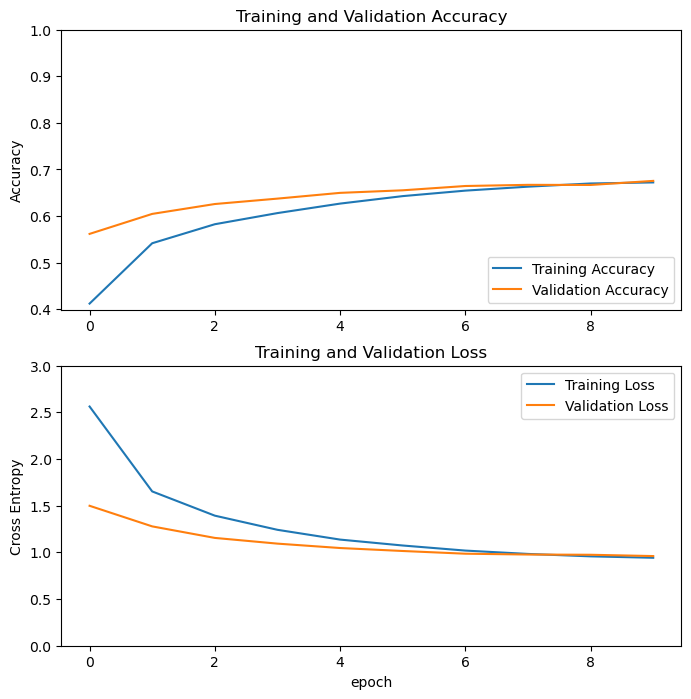

In [485]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,3.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [486]:
base_model.trainable = True

In [487]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  175


In [488]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [489]:
model.summary()

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_29 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 tf.__operators__.getitem_15  (None, 32, 32, 3)        0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_15 (TFOpLamb  (None, 32, 32, 3)        0         
 da)                                                             
                                                                 
 resnet50 (Functional)       (None, 1, 1, 2048)        23587712  
                                                                 
 global_average_pooling2d_12  (None, 2048)             0         
  (GlobalAveragePooling2D)                                       
                                                          

In [490]:
len(model.trainable_variables)

92

In [491]:
fine_tune_epochs = 4
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/14
1563/1563 [==============================] - 1451s 921ms/step - loss: 0.8326 - accuracy: 0.7091 - val_loss: 0.8069 - val_accuracy: 0.7267
Epoch 11/14
1563/1563 [==============================] - 1435s 918ms/step - loss: 0.6474 - accuracy: 0.7754 - val_loss: 0.7681 - val_accuracy: 0.7485
Epoch 12/14
1563/1563 [==============================] - 1444s 924ms/step - loss: 0.5135 - accuracy: 0.8217 - val_loss: 0.7580 - val_accuracy: 0.7584
Epoch 13/14
1563/1563 [==============================] - 1455s 931ms/step - loss: 0.4084 - accuracy: 0.8598 - val_loss: 0.7837 - val_accuracy: 0.7602
Epoch 14/14
1563/1563 [==============================] - 1454s 930ms/step - loss: 0.3154 - accuracy: 0.8932 - val_loss: 0.8340 - val_accuracy: 0.7638


In [492]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

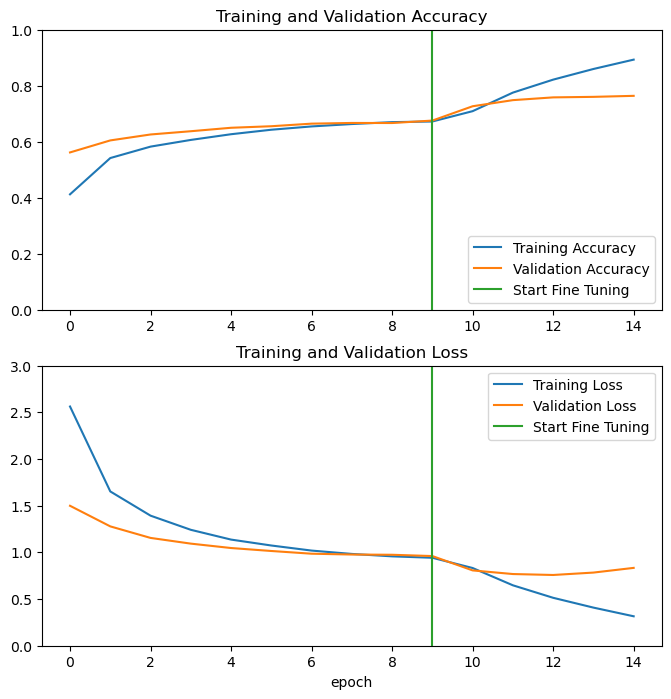

In [493]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 3.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()